# Logistic regression on the MNIST handwritten digits

In this miniproject, you are asked to apply logistic regression to solve the problem of handwritten digit recognition. The data set being used below is rather large in both size and dimension. To speed up computing, you can use PCA to reduce the dimension considerably. You will then apply logistic regression (no regularization) to the dimension reduced data.

Note: One could use the regularization technique (as an alternative to PCA) to handle the many features. It would also effectively handle the issue of multicollinearity but computing is rather intensive.


Import libraries

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
import scipy.io
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
import warnings
from sklearn.multiclass import OneVsOneClassifier
from sklearn.multiclass import OneVsRestClassifier

In [2]:
warnings.filterwarnings('ignore')

load the MNIST data set (you need to first download the file mnist.mat and save it in the same place with the notebook)

In [3]:
mat = scipy.io.loadmat('../datasets/mnist.mat')
mat

{'__header__': b'MATLAB 5.0 MAT-file, Platform: MACI64, Created on: Sat Sep 12 14:11:18 2020',
 '__version__': '1.0',
 '__globals__': [],
 'Xtr': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'Xtst': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'ytr': array([[5],
        [0],
        [4],
        ...,
        [5],
        [6],
        [8]], dtype=uint8),
 'ytst': array([[7],
        [2],
        [1],
        ...,
        [4],
        [5],
        [6]], dtype=uint8)}

In [4]:
X_train = mat['Xtr']
y_train = mat['ytr']
X_test = mat['Xtst']
y_test = mat['ytst']

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((60000, 784), (60000, 1), (10000, 784), (10000, 1))

Apply PCA to reduce the dimension from 784 to 50

In [5]:
pca50 = PCA(n_components=50).fit(X_train)

X_train_pca = pca50.transform(X_train)
X_test_pca = pca50.transform(X_test)

X_train_pca.shape, X_test_pca.shape

((60000, 50), (10000, 50))

The following experiments are all based on the dimension reduced data (training and test).

In [ ]:
def filter_digits(X, y, digits):
    mask = np.isin(y, digits).flatten()
    return X[mask], y[mask].reshape(-1)

def evaluate_model_results(y_true, y_pred, model, axs) -> tuple:
    if axs is None:
        fig, axs = plt.subplots(1, 1)
        
    try:
        model_name = str(model.multi_class).capitalize()
        if model_name == 'Deprecated':
            raise Exception
    except:
        model_name = model.__class__.__name__

    score = accuracy_score(y_true, y_pred)
    error = 1 - score
    
    cm = confusion_matrix(y_true, y_pred)
    # print("Confusion Matrix:\n",cm)
    for ax in np.atleast_1d(axs).flatten():
        if not hasattr(ax, 'used') or not ax.used:
            digits = ', '.join(map(str, model.classes_))
            print(f'{digits} -> {model_name} Test Score: {score*100:.2f}%')
            print(f'{digits} -> {model_name} Test Error: {error*100:.2f}%')
            disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                    display_labels=model.classes_)
            disp.plot(ax=ax)
            disp.ax_.set_title(f'{digits} {model_name} Confusion Matrix')
            ax.used = True
            break
    return score, error

def fit_model(X_train, y_train, X_test, y_test, model, fig=None, axs=None) -> tuple:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return evaluate_model_results(y_true=y_test, y_pred=y_pred, model=model, axs=axs)

## (1) Classifying a pair of digits

First, let's consider the pair $\mathbf{\{0,1\}}$, which should be relatively easy. Train a binary logistic regression classifier on all the training images that contain either digit and evaluate the trained classifer on the test images containing one of the two digits. Display the confusion matrix. What is the overall classification error?

In [7]:
X_train_01, y_train_01 = filter_digits(X_train_pca, y_train, [0, 1])

LogisticModelfull = LogisticRegression(C=1e5,max_iter=500).fit(X_train_01, y_train_01)

In [8]:
X_test_01, y_test_01 = filter_digits(X_test_pca, y_test, [0, 1])

pred = LogisticModelfull.predict(X_test_01)

n_test_01 = y_test_01.shape[0]

accuracy_01 = np.sum(pred == y_test_01)/n_test_01
accuracy_01

0.9985815602836879

0, 1 -> LogisticRegression Test Score: 99.86%
0, 1 -> LogisticRegression Test Error: 0.14%


(0.9985815602836879, 0.0014184397163120588)

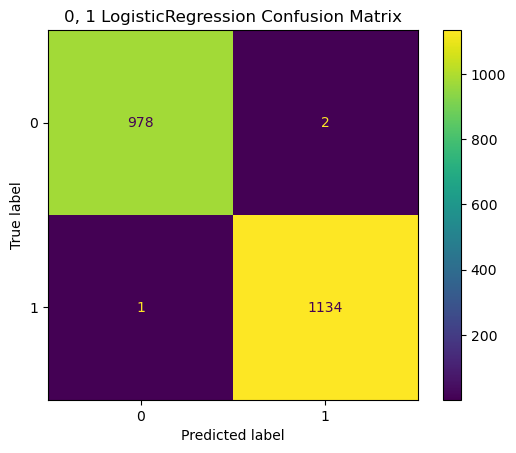

In [9]:
fit_model(X_train_01, y_train_01, X_test_01, y_test_01, LogisticModelfull)

Do the same thing with the pair $\mathbf{\{1,7\}}$ instead. How does it compare with the pair {0,1} in terms of overall error?

In [10]:
X_train_pca_1_7, y_train_1_7 = filter_digits(X_train_pca, y_train, [1, 7])
X_test_pca_1_7, y_test_1_7 = filter_digits(X_test_pca, y_test, [1, 7])

LogisticModel1_7 = LogisticRegression(C=1e5,max_iter=500).fit(X_train_pca_1_7, y_train_1_7)

pred = LogisticModel1_7.predict(X_test_pca_1_7)
n_test_17 = y_test_1_7.shape[0]

accuracy_17 = np.sum(pred == y_test_1_7.ravel())/n_test_17
accuracy_17

0.9926028663892742

1, 7 -> LogisticRegression Test Score: 99.26%
1, 7 -> LogisticRegression Test Error: 0.74%


(0.9926028663892742, 0.0073971336107258034)

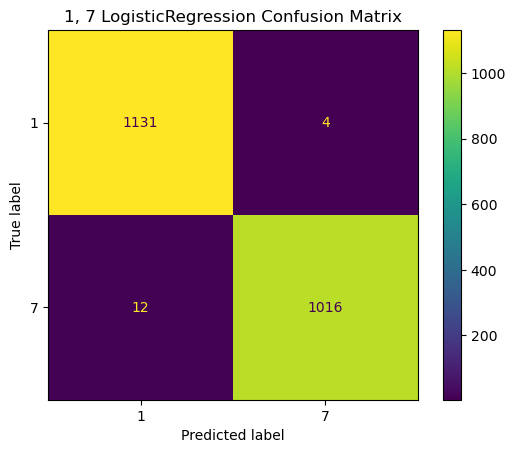

In [11]:
fit_model(X_train_pca_1_7, y_train_1_7, X_test_pca_1_7, y_test_1_7, LogisticModel1_7)

Which pair of digits do you think are the hardest to distinguish? Perform binary logistic regression with those images (training and test) and report the overall error.

#### (7 and 9 -> accuracy 95.83%), (3 and 5 -> accuracy 95.16%), (5 and 8 -> accuracy 95.55%),      

In [12]:
a = 5
b = 8
X_train_pca_a = X_train_pca[y_train.ravel()==a,:]
y_train_a = y_train[y_train.ravel()==a,:]


X_train_pca_b = X_train_pca[y_train.ravel()==b,:]
y_train_b = y_train[y_train.ravel()==b,:]


X_train_pca_ab = np.concatenate((X_train_pca_a, X_train_pca_b))
y_train_ab = np.concatenate((y_train_a, y_train_b))


LogisticModelab = LogisticRegression(C=1e5,max_iter=500).fit(X_train_pca_ab, y_train_ab.ravel())

X_test_pca_a = X_test_pca[y_test.ravel()==a,:]
y_test_a = y_test[y_test.ravel()==a,:]

X_test_pca_b = X_test_pca[y_test.ravel()==b,:]
y_test_b = y_test[y_test.ravel()==b,:]


X_test_pca_ab = np.concatenate((X_test_pca_a, X_test_pca_b))

y_test_ab = np.concatenate((y_test_a, y_test_b))

pred = LogisticModelab.predict(X_test_pca_ab)

n_test_ab = y_test_ab.shape[0]


accuracy_ab = np.sum(pred == y_test_ab.ravel())/n_test_ab

accuracy_ab

0.954983922829582

7, 9 -> LogisticRegression Test Score: 95.88%
7, 9 -> LogisticRegression Test Error: 4.12%

3, 5 -> LogisticRegression Test Score: 95.11%
3, 5 -> LogisticRegression Test Error: 4.89%

5, 8 -> LogisticRegression Test Score: 95.50%
5, 8 -> LogisticRegression Test Error: 4.50%

Hardest digits to distiguish: [3, 5]


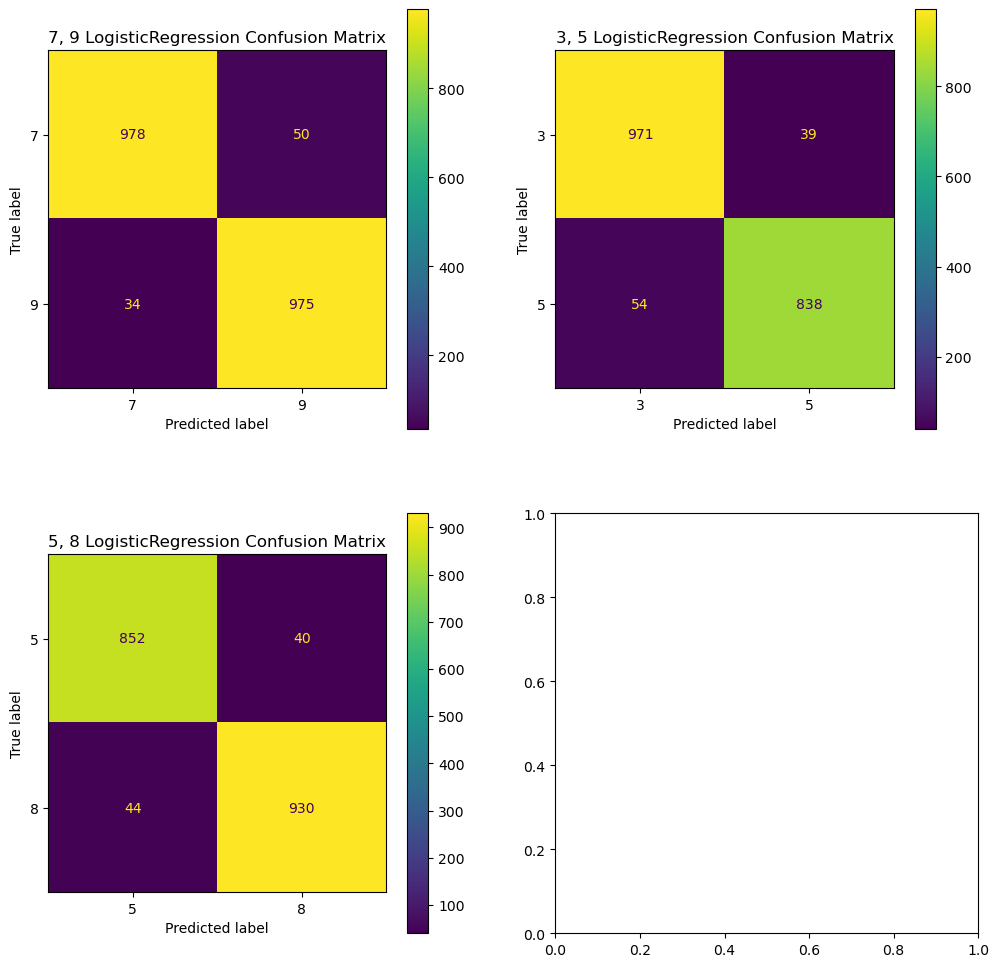

In [25]:
digits = [[7, 9], [3, 5], [5, 8]]

fig, axs = plt.subplots(2, 2, figsize=(12, 12))
errors = []
for digit_pair in digits:
    X_train_filter, y_train_filter = filter_digits(X_train_pca, y_train, digit_pair)
    X_test_filter, y_test_filter = filter_digits(X_test_pca, y_test, digit_pair)

    LogisticModel = LogisticRegression(C=1e5,max_iter=500).fit(X_train_filter, y_train_filter)
    
    score, error = fit_model(X_train_filter, y_train_filter, X_test_filter, y_test_filter, LogisticModel, fig, axs)
    errors.append(error)
    print()

hardest_digits = digits[np.argmax(errors)]
print(f'Hardest digits to distiguish: {hardest_digits}')

## (2) Classifying three digits together

Consider the triple of digits $\mathbf{\{0,1,2\}}$, which should also be relatively easy. We need to train a multiclass logistic regression classifier on all the training images that contain the three digit and evaluate the trained classifer on the test images containing one of the three digits. There are three ways to extend binary logistic regression to the multiclass setting.

(2a) Perform the $\textbf{one-versus-rest}$ multiclass logistic regression on the three digits {0,1,2} and report the overall test error.

In [14]:
digits = [0, 1, 2]

X_train_pca_filter, y_train_pca_filter = filter_digits(X_train_pca, y_train, digits)
X_test_pca_filter, y_test_pca_filter = filter_digits(X_test_pca, y_test, digits)

# Checking unique values in y_train_pca_filter
set(y_train_pca_filter)

{0, 1, 2}

0, 1, 2 -> OneVsRestClassifier Test Score: 98.54%
0, 1, 2 -> OneVsRestClassifier Test Error: 1.46%


(0.9853829043533524, 0.014617095646647593)

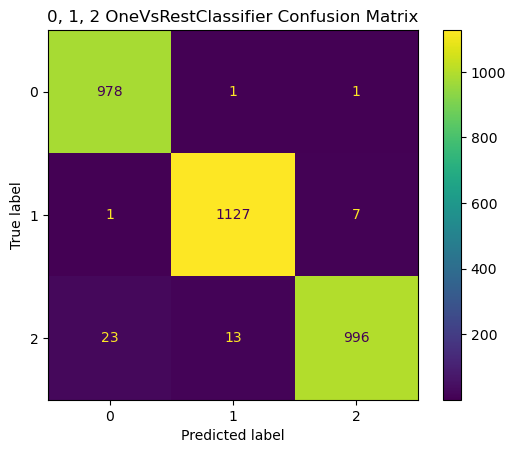

In [15]:
OneVsRest = OneVsRestClassifier(LogisticRegression(multi_class='ovr', solver='lbfgs'))
fit_model(X_train_pca_filter, y_train_pca_filter, X_test_pca_filter, y_test_pca_filter, OneVsRest)

(2b) Perform $\textbf{multinomial}$ logistic regression with the three digits {0,1,2} and report the overall test error.

0, 1, 2 -> Multinomial Test Score: 98.89%
0, 1, 2 -> Multinomial Test Error: 1.11%


(0.9888782967905942, 0.011121703209405753)

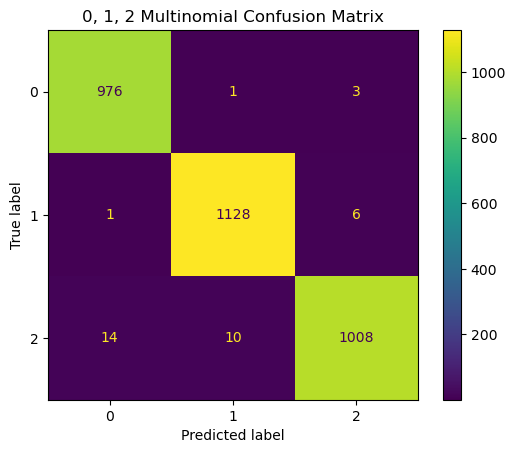

In [16]:
Multinomial = LogisticRegression(multi_class='multinomial', solver='lbfgs')
fit_model(X_train_pca_filter, y_train_pca_filter, X_test_pca_filter, y_test_pca_filter, Multinomial)

(2c) Perform the $\textbf{one-versus-one}$ multiclass logistic regression on the three digits {0,1,2} and report the overall test error. You will need to implment this extension from scratch first.

0, 1, 2 -> OneVsOneClassifier Test Score: 98.82%
0, 1, 2 -> OneVsOneClassifier Test Error: 1.18%


(0.9882427708929139, 0.011757229107086098)

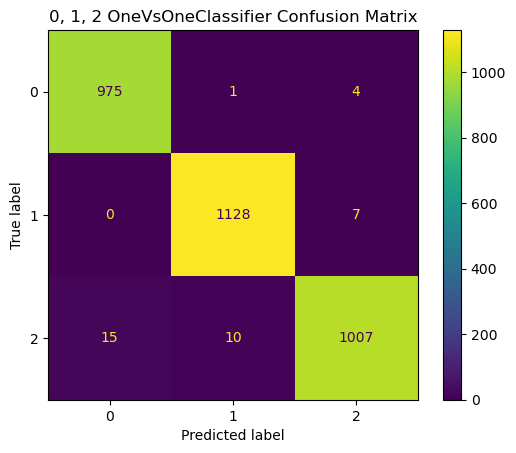

In [17]:
OneVsOne = OneVsOneClassifier(LogisticRegression(solver='lbfgs'))
fit_model(X_train_pca_filter, y_train_pca_filter, X_test_pca_filter, y_test_pca_filter, OneVsOne)

(2d) Which combination of three digits do you think are the hardest to distinguish? Perform each of the three extensions of multiclass logistic regression with those images (training and test) and report the overall test errors (using a bar plot).

#### I would expect the digits {3, 5, 8} to be the hardest to distinguish due to their similar shapes and curves.
##### This is supported when you look at a PCA plot of the digits; the digits {3, 5, 8} are all clustered together in the PCA plot.

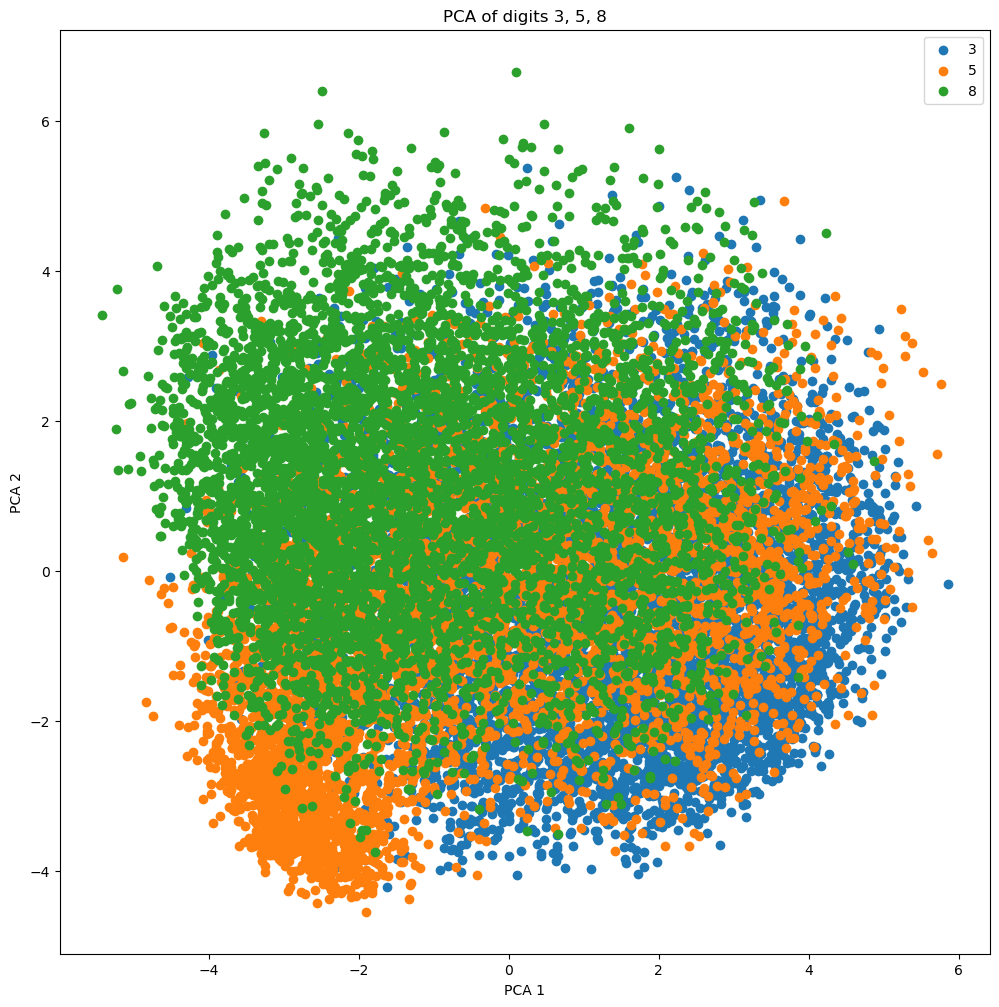

In [ ]:
# PCA plot of the digitis 3,5,8
digits = [3, 5, 8]
X_train_pca_filter, y_train_pca_filter = filter_digits(X_train_pca, y_train, digits)
X_test_pca_filter, y_test_pca_filter = filter_digits(X_test_pca, y_test, digits)

pca = PCA(n_components=2)
X_train_pca_2d = pca.fit_transform(X_train_pca_filter)
X_test_pca_2d = pca.transform(X_test_pca_filter)

fig, ax = plt.subplots(1, 1, figsize=(12, 12))
for digit in digits:
    mask = y_train_pca_filter == digit
    ax.scatter(X_train_pca_2d[mask, 0], X_train_pca_2d[mask, 1], label=f'{digit}')
ax.legend()
ax.set_title('PCA of digits 3, 5, 8')
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
plt.show()


3, 5, 8 -> OneVsRestClassifier Test Score: 91.97%
3, 5, 8 -> OneVsRestClassifier Test Error: 8.03%

3, 5, 8 -> Multinomial Test Score: 92.25%
3, 5, 8 -> Multinomial Test Error: 7.75%

3, 5, 8 -> OneVsOneClassifier Test Score: 92.70%
3, 5, 8 -> OneVsOneClassifier Test Error: 7.30%

The best model is OneVsOneClassifier with an error of 7.30%


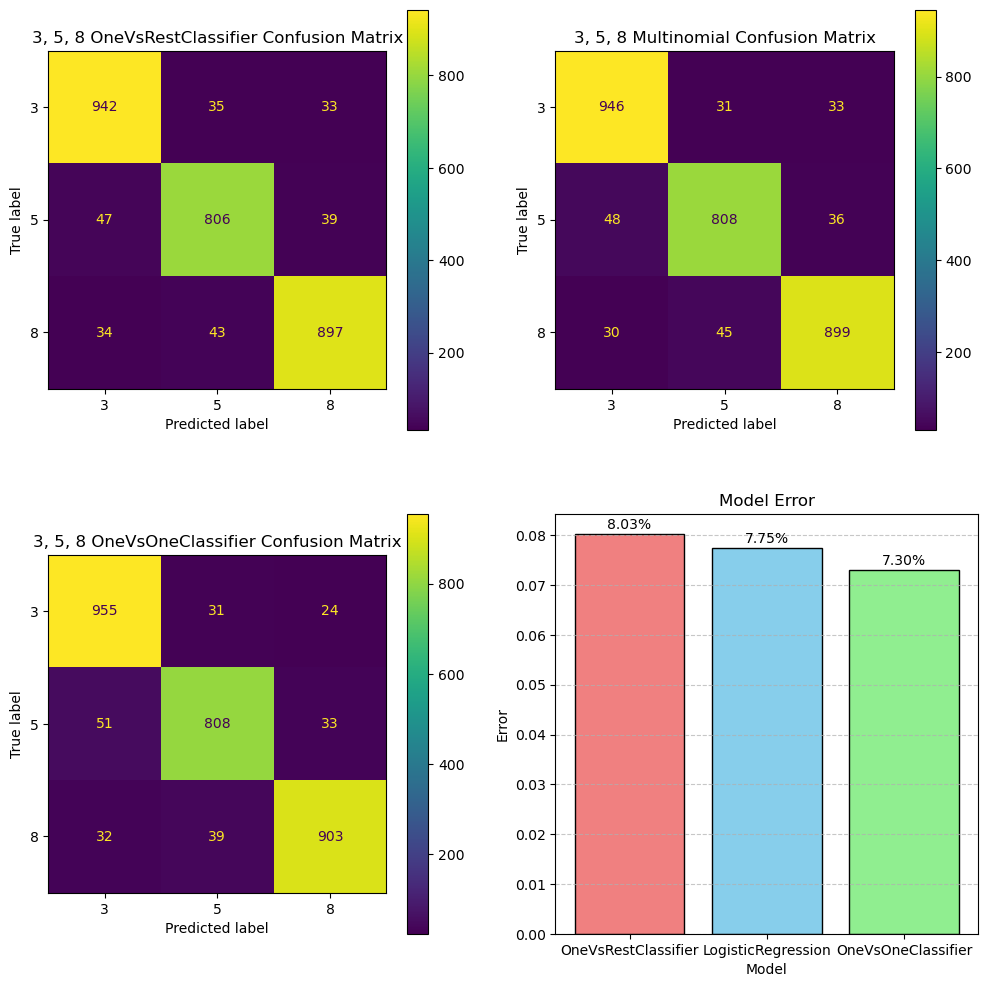

<Figure size 640x480 with 0 Axes>

In [18]:
digits = [3, 5, 8]
models = [OneVsRestClassifier(LogisticRegression(multi_class='ovr', solver='lbfgs')),
           LogisticRegression(multi_class='multinomial', solver='lbfgs'), 
           OneVsOneClassifier(LogisticRegression(solver='lbfgs'))]

X_train_pca_filter, y_train_pca_filter = filter_digits(X_train_pca, y_train, digits)
X_test_pca_filter, y_test_pca_filter = filter_digits(X_test_pca, y_test, digits)

errors = []
fig, axs = plt.subplots(2, 2, figsize=(12, 12))
for model in models:
    score, error = fit_model(X_train_pca_filter, y_train_pca_filter, X_test_pca_filter, y_test_pca_filter, model, fig, axs)
    errors.append(error)
    print()

best_model = models[np.argmin(errors)].__class__.__name__
print(f'The best model is {best_model} with an error of {min(errors)*100:.2f}%')

# Plotting the error of each model
plt.figure()
axs[1, 1].bar([model.__class__.__name__ for model in models], errors, color=['lightcoral', 'skyblue', 'lightgreen'], edgecolor='black')
axs[1, 1].set_xlabel('Model')
axs[1, 1].set_ylabel('Error')
axs[1, 1].set_title('Model Error')
axs[1, 1].grid(axis='y', linestyle='--', alpha=0.7)

for i, error in enumerate(errors):
    axs[1, 1].text(i, error + 0.001, f'{error*100:.2f}%', ha='center')


## (3) Classify all 10 digits simultaneously

Perform each of the three extensions of multiclass logistic regression with the full data set and report the overall test errors (using a bar plot).

One-vs-rest Accuracy: 90.48%


Text(0.5, 1.0, '10 Digits One-vs-rest Confusion Matrix')

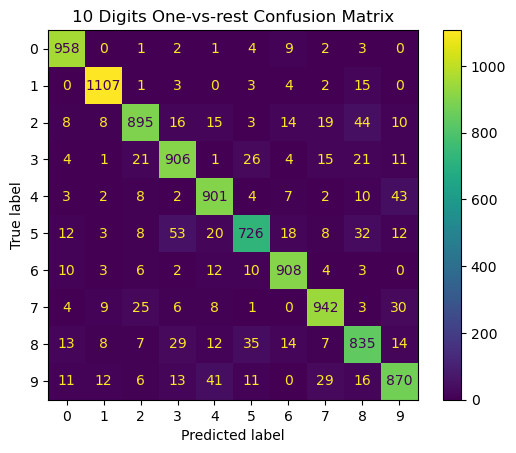

In [19]:
#Evaluate OneVsRest Model
OneVsRest_model = OneVsRestClassifier(LogisticRegression(multi_class='ovr', solver='lbfgs'))
OneVsRest_model.fit(X_train_pca, y_train.ravel())

y_pred_ovr = OneVsRest_model.predict(X_test_pca)
ovr_accuracy = accuracy_score(y_test, y_pred_ovr)
ovr_error = 1 - ovr_accuracy

print(f"One-vs-rest Accuracy: {ovr_accuracy* 100:.2f}%")
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred_ovr),
                             display_labels=OneVsRest_model.classes_)
disp.plot()
disp.ax_.set_title("10 Digits One-vs-rest Confusion Matrix")

Multinomial Accuracy: 91.17%


Text(0.5, 1.0, '10 Digits Multinomial Confusion Matrix')

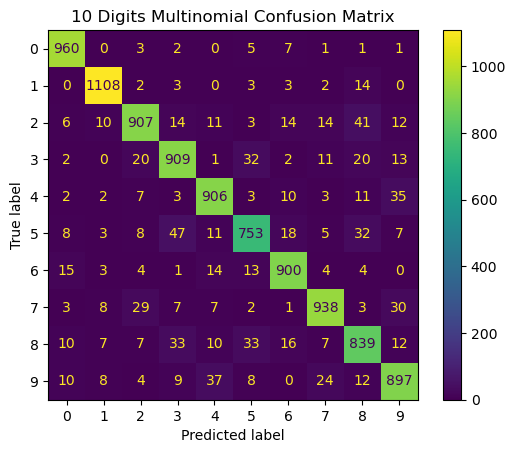

In [20]:
#Evaluate Multinomial Model
Multinomial_model = LogisticRegression(multi_class='multinomial', solver='lbfgs')
Multinomial_model.fit(X_train_pca, y_train.ravel())

y_pred_multinomial = Multinomial_model.predict(X_test_pca)
multinomial_accuracy = accuracy_score(y_test, y_pred_multinomial)
multinomial_error = 1 - multinomial_accuracy

print(f"Multinomial Accuracy: {multinomial_accuracy* 100:.2f}%")
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred_multinomial),
                             display_labels=Multinomial_model.classes_)
disp.plot()
disp.ax_.set_title("10 Digits Multinomial Confusion Matrix")

OneVsOne: 93.52%


Text(0.5, 1.0, '10 Digits OneVsOne Confusion Matrix')

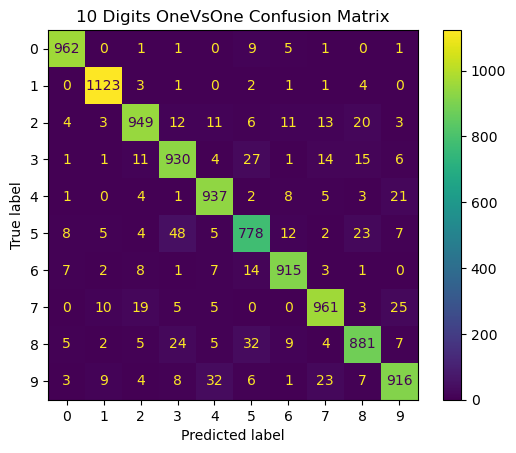

In [21]:
# Evaluate OneVsOne Model
OneVsOne_model = OneVsOneClassifier(LogisticRegression(solver='lbfgs'))
OneVsOne_model.fit(X_train_pca, y_train.ravel())

y_pred_ovo = OneVsOne_model.predict(X_test_pca)
ovo_accuracy = accuracy_score(y_test, y_pred_ovo)
ovo_error = 1 - ovo_accuracy

print(f"OneVsOne: {ovo_accuracy* 100:.2f}%")
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred_ovo),
                             display_labels=OneVsOne_model.classes_)
disp.plot()
disp.ax_.set_title("10 Digits OneVsOne Confusion Matrix")

<function matplotlib.pyplot.show(close=None, block=None)>

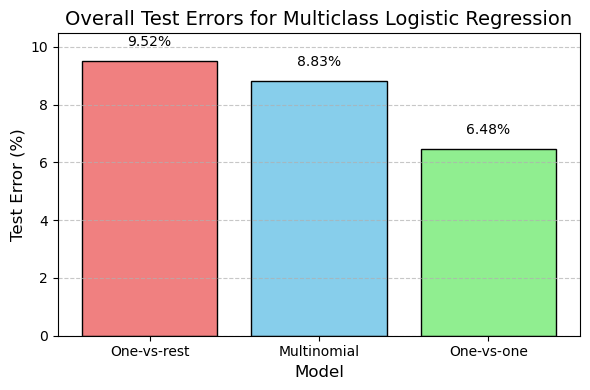

In [22]:
# Create a bar plot
models = ['One-vs-rest', 'Multinomial', 'One-vs-one']
errors = [ovr_error, multinomial_error, ovo_error]
errors_percentage = np.array(errors) * 100


plt.figure(figsize=(6, 4))  
plt.bar(models, errors_percentage, color=['lightcoral', 'skyblue', 'lightgreen'], edgecolor='black') 
plt.title('Overall Test Errors for Multiclass Logistic Regression', fontsize=14) 
plt.xlabel('Model', fontsize=12)  
plt.ylabel('Test Error (%)', fontsize=12)  
plt.xticks(fontsize=10)  
plt.yticks(fontsize=10)  
plt.grid(axis='y', linestyle='--', alpha=0.7)  
plt.ylim(0, max(errors_percentage) * 1.1)  

# Add error values as text above the bars
for i, error in enumerate(errors):
    plt.text(i, errors_percentage[i] + 0.5, f'{errors_percentage[i]:.2f}%', ha='center', fontsize=10)

plt.tight_layout()  
plt.show

Summarize your findings by commenting on which version of multiclass logistic regression works the best on the handwritten digits dataset and which digits are the hardest to be distinguished from the rest.

**Findings**\
The One-vs-One version of multiclass logistic regression works the best on the MNIST handwritten digits dataset. This regression had a test error of **6.48%**. 

The digit pairs which were hardest to distinguish accurately with these three methods were

---

|  True Label | Predicted Label |
|---|---|
| 5 | 3 |
| 8 | 5 |
| 3 | 5 |
| 2 | 8 |